In [38]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances  # 若未使用，可保留以兼容后续逻辑

seed = 42
np.random.seed(seed)

# 生成10个来自 N(80, 10) 的随机数
Basic = np.random.normal(80, 5, 16)
Patterns = np.random.normal(78, 5, 6)
Contact = np.random.normal(75, 5, 15)
Instrument = np.random.normal(75, 5, 12)
Basic_formation = np.random.normal(78, 5, 21)
Tactical_formation = np.random.normal(72, 5, 9)
Low_level = np.random.normal(72, 5, 8)
Four_Ship_formation = np.random.normal(72, 5, 8)
CAF_introduction = np.random.normal(68, 5, 21)
MAF_introduction = np.random.normal(70, 5, 12)
mu_data = [Basic,Patterns,Contact,Instrument,Basic_formation,Tactical_formation,Low_level,Four_Ship_formation,CAF_introduction,MAF_introduction]

mu = np.concatenate(mu_data)
np.savetxt('mu.txt', 
           mu,
           fmt='%.6f',
           header='真实均值')

In [39]:
mu_data

[array([82.48357077, 79.30867849, 83.23844269, 87.61514928, 78.82923313,
        78.82931522, 87.89606408, 83.83717365, 77.65262807, 82.71280022,
        77.68291154, 77.67135123, 81.20981136, 70.43359878, 71.37541084,
        77.18856235]),
 array([72.9358444 , 79.57123666, 73.45987962, 70.93848149, 85.32824384,
        76.8711185 ]),
 array([75.33764102, 67.87625907, 72.27808638, 75.55461295, 69.24503211,
        76.87849009, 71.99680655, 73.54153125, 71.99146694, 84.26139092,
        74.93251388, 69.71144536, 79.11272456, 68.89578175, 76.04431798]),
 array([65.20164938, 68.35906976, 75.98430618, 78.6923329 , 75.85684141,
        74.42175859, 73.49448152, 67.60739005, 71.40077896, 72.69680615,
        80.28561113, 76.71809145]),
 array([69.18479922, 79.62041985, 76.0745886 , 74.61539   , 81.05838144,
        83.15499761, 82.6564006 , 73.80391238, 76.45393812, 79.65631716,
        82.87772564, 75.60412881, 77.07170512, 72.46832513, 72.01896688,
        82.06262911, 84.78120014, 77.639

In [40]:
from typing import List, Tuple
import numpy as np

def generate_grouped_variances(
    means_groups: List[List[float]],
    *,
    center: float = 75.0,
    s_ind: float = 12.0,   # 个体极端度的尺度：|m - center| / s_ind
    s_grp: float = 6.0,    # 组带偏的尺度：|group_mean - center| / s_grp
    alpha: float = 0.34,   # 个体极端度权重
    beta: float = 0.33,    # 组带偏权重
    gamma: float = 0.33,   # 随机扰动权重（乘以 rand()）
    var_min: float = 9.0,
    var_max: float = 100.0,
    seed: int = 42
) -> List[List[float]]:
    """
    依据“个体极端度 + 组带偏”的双层抑制策略生成方差。
    返回的结构与输入分组均值结构一致。
    """
    rng = np.random.default_rng(seed)

    # 预计算每组的组均值及其带偏 g_j
    group_means = [float(np.mean(g)) if len(g) > 0 else center for g in means_groups]
    g_vals = [min(abs(gm - center) / s_grp, 1.0) for gm in group_means]

    variances_groups: List[List[float]] = []

    for j, group in enumerate(means_groups):
        g_j = g_vals[j]
        group_vars: List[float] = []

        for m in group:
            # 个体极端度
            e_i = min(abs(m - center) / s_ind, 1.0)

            # 基础随机方差
            v_base = rng.uniform(var_min, var_max)

            # 缩放因子：双层抑制 + 随机扰动
            shrink = 1.0 - alpha * e_i - beta * g_j + gamma * rng.random()

            # 应用缩放并裁剪到范围
            v = max(var_min, min(var_max, v_base * max(0.0, shrink)))
            group_vars.append(round(v, 2))  # 保留两位小数

        variances_groups.append(np.array(group_vars))

    return variances_groups

var_data = generate_grouped_variances(means_groups=mu_data,seed=seed)
var_data


[array([52.8 , 73.2 , 14.42, 50.98, 15.95, 39.72, 44.85, 27.47, 40.31,
        60.87, 60.28, 92.57, 49.52, 31.76, 19.69, 75.95]),
 array([37.89, 43.95, 21.45, 30.32, 43.84, 70.3 ]),
 array([100.  ,  36.72,  64.38,  25.1 ,  80.03,  83.47,  52.74,  20.26,
         70.29,  55.99,  74.58,  53.11,  11.38,  25.63,  85.28]),
 array([10.4 , 33.64, 68.19, 65.36, 78.3 , 10.24, 76.33, 20.54, 23.76,
        48.22, 35.34, 37.39]),
 array([19.47, 85.62, 37.29, 84.63, 37.53, 16.01, 34.51, 36.52, 26.98,
        73.3 , 39.51, 64.1 , 15.22, 11.83, 31.1 , 15.24, 21.14, 54.06,
        38.56, 82.46, 68.58]),
 array([53.78, 88.39, 45.79, 35.89, 26.83, 96.44, 21.57, 18.42, 35.52]),
 array([52.95, 18.37, 23.02, 46.93, 75.99, 34.29, 28.55, 34.07]),
 array([19.42, 48.64, 96.29, 95.2 , 49.78, 68.74, 31.53, 59.99]),
 array([38.6 , 15.89, 13.03, 48.36, 14.54, 51.89, 25.08,  9.  , 12.21,
        12.37, 52.02, 23.55, 54.86, 11.49, 55.33, 17.87, 54.3 , 27.54,
         9.  , 31.97, 14.21]),
 array([79.12, 68.02, 51.78

协方差矩阵形状: (128, 128)
相关矩阵最小特征值: -0.07624429307853504
各组内相关均值（期望~0.65）: [0.762 0.735 0.66  0.584 0.549 0.675 0.548 0.735 0.718 0.66 ]
组间相关均值（期望~0.10）: 0.1


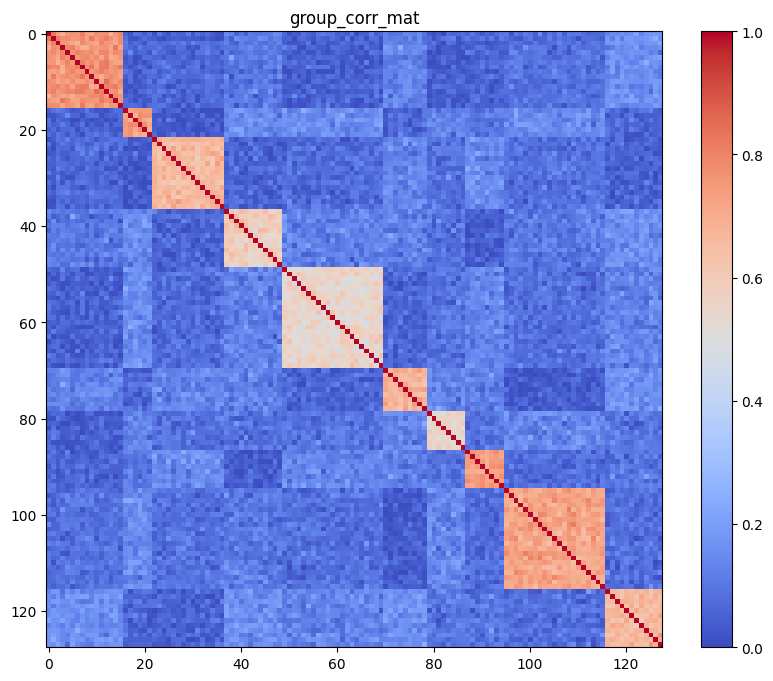

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def nearest_pd(A):
    """
    Higham (1988) 最近正定矩阵的简化实现：
    保持对称、提高到最近的半正定，再把对角修复为 1。
    """
    B = (A + A.T) / 2.0
    # SVD
    U, s, Vt = np.linalg.svd(B, full_matrices=False)
    H = Vt.T @ np.diag(s) @ Vt
    A2 = (B + H) / 2.0
    A3 = (A2 + A2.T) / 2.0
    # 若仍非正定，做小幅对角平移
    w = np.linalg.eigvalsh(A3)
    min_eig = w.min()
    if min_eig < 1e-8:
        A3 += np.eye(A3.shape[0]) * (1e-8 - min_eig + 1e-12)
    # 恢复对角为 1（相关矩阵）
    np.fill_diagonal(A3, 1.0)
    return A3

def build_covariance_from_group_variances(
        var_groups,
        target_intra=0.65,
        target_inter=0.10,
        max_intra=0.85,
        max_inter=0.30,
        min_inter=0.0,
        seed=2025,
        intra_base_spread=0.12,   # 组内基础均值波动幅度（±）
        intra_noise_std=0.06,     # 组内块内元素级噪声
        inter_base_spread=0.08,   # 组间基础均值波动幅度（±）
        inter_noise_std=0.04,     # 组间块内元素级噪声
        eps_pd=1e-6):
    rng = np.random.default_rng(seed)

    # 拼接方差
    group_sizes = [len(g) for g in var_groups]
    total_n = sum(group_sizes)
    assert total_n == 128, f"总元素数应为 128，当前为 {total_n}"
    variances = np.concatenate(var_groups)
    stds = np.sqrt(variances)

    # 分组索引
    group_indices = []
    start = 0
    for sz in group_sizes:
        group_indices.append(np.arange(start, start + sz))
        start += sz

    # 初始化相关矩阵
    R = np.eye(total_n)

    # 组内块：更大波动 + 块内异质性
    for idxs in group_indices:
        sz = len(idxs)
        if sz <= 1:
            continue
        base = target_intra + rng.uniform(-intra_base_spread, intra_base_spread)
        base = np.clip(base, 0.0, max_intra)
        noise = rng.normal(0, intra_noise_std, size=(sz, sz))
        block = base + (noise + noise.T) / 2.0
        np.fill_diagonal(block, 1.0)
        block = np.clip(block, 0.0, max_intra)
        R[np.ix_(idxs, idxs)] = block

    # 组间块：更大波动 + 异质性
    for g1 in range(len(group_indices)):
        for g2 in range(g1 + 1, len(group_indices)):
            idxs1 = group_indices[g1]
            idxs2 = group_indices[g2]
            base = target_inter + rng.uniform(-inter_base_spread, inter_base_spread)
            base = np.clip(base, min_inter, max_inter)
            noise = rng.normal(0, inter_noise_std, size=(len(idxs1), len(idxs2)))
            block = np.clip(base + noise, min_inter, max_inter)
            R[np.ix_(idxs1, idxs2)] = block
            R[np.ix_(idxs2, idxs1)] = block.T

    # 初步正定性处理：最小特征值平移
    w = np.linalg.eigvalsh(R)
    min_eig = w.min()
    if min_eig < eps_pd:
        R += np.eye(total_n) * ((eps_pd - min_eig) + 1e-8)

    # 最近正定投影（更稳），并保持对角=1
    R = nearest_pd(R)

    # 由于最近正定投影可能引入极少数越界，把非对角再裁剪到区间内，并再做一次 PD 投影
    offdiag_mask = ~np.eye(total_n, dtype=bool)
    intra_mask = np.zeros((total_n, total_n), dtype=bool)
    for idxs in group_indices:
        intra_mask[np.ix_(idxs, idxs)] = True
    inter_mask = offdiag_mask & (~intra_mask)

    R[intra_mask & offdiag_mask] = np.clip(R[intra_mask & offdiag_mask], 0.0, max_intra)
    R[inter_mask] = np.clip(R[inter_mask], min_inter, max_inter)

    R = nearest_pd(R)  # 再次投影，确保最终正定

    # 构造协方差
    D = np.diag(stds)
    Sigma = D @ R @ D

    return Sigma, R, group_indices

Sigma, R, groups = build_covariance_from_group_variances(var_data)

print("协方差矩阵形状:", Sigma.shape)
# 可选：简单检验
evals = np.linalg.eigvalsh(R)
print("相关矩阵最小特征值:", evals.min())
# 检查组内/组间相关的统计
# 组内均值
intra_means = []
for idxs in groups:
    block = R[np.ix_(idxs, idxs)]
    m = (block.sum() - np.trace(block)) / (len(idxs) * (len(idxs) - 1))
    intra_means.append(m)
print("各组内相关均值（期望~0.65）:", np.round(intra_means, 3))

# 组间均值
inter_vals = []
for g1 in range(len(groups)):
    for g2 in range(g1 + 1, len(groups)):
        b = R[np.ix_(groups[g1], groups[g2])]
        inter_vals.append(b.mean())
print("组间相关均值（期望~0.10）:", np.round(np.mean(inter_vals), 3))

np.savetxt('group_cov.txt', 
           Sigma,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=9-100）\n基于分组相关性矩阵生成')

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(R, cmap='coolwarm', vmin=0, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [42]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 128, 1280).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 129)
y_integers = y_dense[np.linspace(0, 1279, 128, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-128整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-128整数点)\n核函数: {kernel}')